# PCA across compounds

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import xarray as xr

import shnitsel as sh
import shnitsel.xarray

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

## Load molecules

In [2]:
orig = {
    c: sh.open_frames(f'/tmp/{c}_filtered.nc')
    for c in ['I01', 'A01', 'A02', 'A03']
}

## Select homologous/isoelectronic moieties

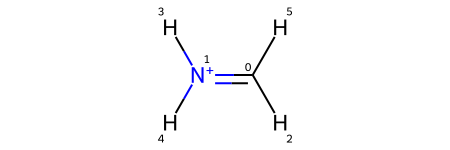

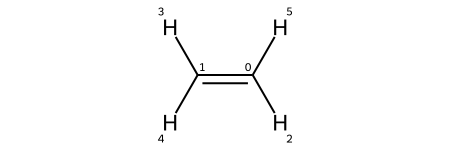

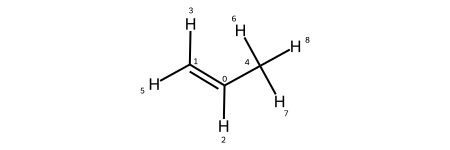

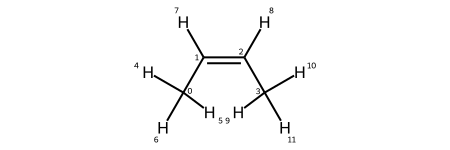

In [3]:
display(orig['I01'].atXYZ.isel(frame=0).sh.to_mol(+1))
display(orig['A01'].atXYZ.isel(frame=0).sh.to_mol())
display(orig['A02'].atXYZ.isel(frame=0).sh.to_mol())
display(orig['A03'].atXYZ.isel(frame=0).sh.to_mol())

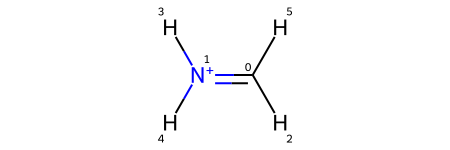

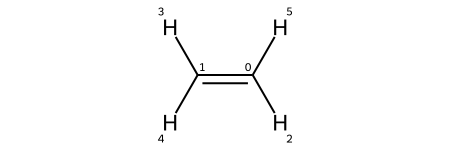

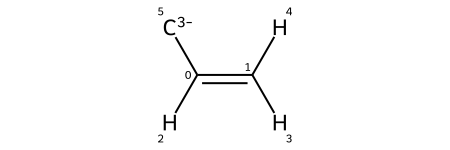

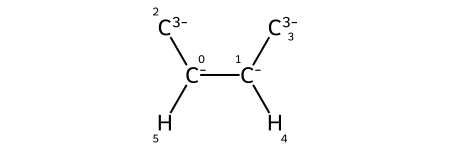

In [4]:
iso = {
    'I01': orig['I01'].drop_dims('state2'),
    'A01': orig['A01'].drop_dims('state2'),
    'A02': (
        orig['A02'].drop_dims('state2')
        .isel(atom=slice(0,6))
        # Put atom indices in order consistent with I01 & A01:
        .assign_coords(atom=[0, 1, 2, 3, 5, 4]).sortby('atom')),
    'A03': (
        orig['A03']
        .isel(atom=[0,1,2,3,7,8])
        # Put atom indices in order consistent with I01 & A01:
        .assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom'))
}
display(iso['I01'].atXYZ.isel(frame=0).sh.to_mol(+1))
display(iso['A01'].atXYZ.isel(frame=0).sh.to_mol())
display(iso['A02'].atXYZ.isel(frame=0).sh.to_mol(-3))
display(iso['A03'].atXYZ.isel(frame=0).sh.to_mol(-8))

In [5]:
homologs = xr.concat(
    [iso[c].sh.expand_midx('frame', 'cmpnd', c) for c in iso],
    dim='frame'
)
homologs

<xarray.Dataset> Size: 340MB
Dimensions:    (state: 3, frame: 53332, direction: 3, statecomb: 3, atom: 6,
                trajid_: 255)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 13 17 19 20 ... 938 944 947 954 961 969
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 427kB MultiIndex
  * cmpnd      (frame) object 427kB 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    atNames    (frame, atom) <U1 1MB 'C' 'N' 'H' 'H' 'H' ... 'C' 'C' 'C' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 1MB 0.3296 0.579 0.9188 ... 15.66 15.52
    dip_perm   (state, direction, frame) float64 4MB -0.001122 ... -0.01176
    dip_trans  (statecomb, direction, frame) float64 4MB 0.000616 ... 0.7723
    sdiag      (frame) int64 427kB 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 427kB 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 1
    forces     (state, atom, direction, frame) float64 23MB 0.09112 0.0 ... 0.0
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 23MB 0.01589 ... -...
    atXYZ      (atom, direction, frame) float64 8MB 0.01587 0.01682 ... -1.382
    max_ts     (trajid_, frame) float64 109MB 200.0 200.0 200.0 ... nan nan nan
    completed  (trajid_, frame) float32 54MB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    nsteps     (trajid_, frame) float64 109MB 201.0 201.0 201.0 ... nan nan nan
    e_kin      (frame) float64 427kB nan nan nan nan ... 6.424 6.936 7.527 8.137
Attributes:
    delta_t:  0.5

In [6]:
pca = homologs.atXYZ.sh.pairwise_dists_pca()
pca

<xarray.DataArray (frame: 53332, PC: 2)> Size: 853kB
array([[-0.44951167, -0.23544693],
       [-0.45213316, -0.20799369],
       [-0.44065323, -0.17830539],
       ...,
       [ 0.55344545,  0.03240821],
       [ 0.55749994, -0.02263981],
       [ 0.56073221, -0.08086804]], shape=(53332, 2))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) object 427kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: PC

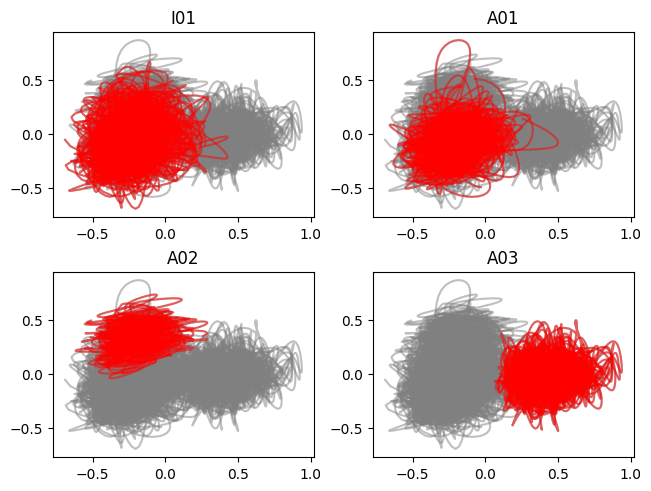

In [7]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='r', alpha=0.5)

In [8]:
homologs.sh.save_frames('/tmp/homologs.nc', complevel=5)

/git/shnitsel-tools/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
